# **Homework 3 - DNA Mutations Leading to Truncated Proteins**

This homework demonstrates various data analysis methodologies and techniques for identifying truncating mutations and how they affect the translated gene product, or protein.

License: This document is open source under [CC BY-ND 4.0](https://en.wikipedia.org/wiki/Creative_Commons_license).

# **Completing the Assignment**

This notebook is your homework #3. To complete the homework and receive credit, you need to work through all 4 sections. Within each thematic section is a mix of explanatory text cells and code cells. Some code cells have code written for you; some ask you to write code. At the end of each section are 'Practice Problems'. You should write code to answer the questions - following the directions given. Once you are ready to submit your answer, run the submission code block below every question block. If you get a question wrong, fix your code and try again. If you get stumped, ask for a hint using the hint code block below each submission code block.

Your first step will be to save this notebook as a copy so that you can edit it. (File->Save a copy in Drive).

Have fun.

# **Learning Outcomes**
#### Biological

*   Classify mutation impact on primary sequence, domain structure, and protein function.

#### Computational

*   Create new DataFrame elements with .apply() function.
*   Access UniProt knowledgebase using API.
*   Import/export data from Colabs.

# **Topics and Background Reading**

In homework 3 we are working on truncating mutations. Throughout this homework, remember that the word **gene** refers to an element of DNA, and the **protein** is a set of amino acids. Thus a gene has a mutation and the protein is truncated. There are a few ways for DNA mutations to cause a truncated protein
- [Nonsense mutation](https://en.wikipedia.org/wiki/Nonsense_mutation): a mutation of a single base pair in a DNA sequence that leads to the creation of a stop codon where previously there was a codon specifying an amino acid.
- [Frameshift mutation](https://en.wikipedia.org/wiki/Frameshift_mutation): an insertion or deletion in a DNA sequence that changes the translation reading frame, usually resulting in an early stop codon.

Readings assigned this week for learning about truncating mutations and their effect in cancer.

- [Townsend 1994](https://pubmed.ncbi.nlm.nih.gov/7935811/)
- [Holstege 2009](https://pubmed.ncbi.nlm.nih.gov/19336573/)

A second topic this week is about protein function, and specifically domains. [Protein Domains](https://en.wikipedia.org/wiki/Protein_domain) are regions of a protein which naturally and independently fold and are often associated with a function (like being the region of an enzyme where substrate binding and catalysis happens). Because they are structurally and functionally important, domains are under positive selection to preserve their structure and function. Domains can be computationally recognized by their sequence.

- [Sonnhammer 1998](https://pubmed.ncbi.nlm.nih.gov/9399864/)

# Part 1. Setup

Google Colabs is a web service that allows you to write interactive Python ([iPython](https://en.wikipedia.org/wiki/IPython)) in notebooks. This web service runs on a virtual computer (virtual machine or VM) that is set up just for you. Initially, that VM only includes the most common Python libraries. So we first need to install our *cptac* and *biogader* packages on the VM. This is done with a server directive, which is recognized because it starts with '!'.

In [ ]:
!pip install cptac==1.1.0
!pip install biograder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
  Attempting uninstall: polars
    Found existing installation: polars 0.17.3
    Uninstalling polars-0.17.3:
      Successfully uninstalled polars-0.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 6.2.0 requires pyarrow<13,>=2, but you have pyarrow 14.0.2 which is incompatible.


Next step in the setup will be familiar as we import packages. We also need to download (onto the VM) the cptac datasets. Finally we instantiate the dataset object that we'll be working with.

In [ ]:
#Be patient, this may take a few minutes depending on your internet connection.
import cptac

cptac.download('ovarian')
#Instantiate a data object, the ovarian cancer dataset.
ov = cptac.Ovarian()

We also need to get the homework autograder. This will have the same steps of importing and object creation.

In [ ]:
import biograder
#The truncating mutations homework is #3
biograder.download("bio462_hw3")
myID = "s15211" #Your student id, or 'temp'
hw = biograder.bio462_hw3(student_id = myID) #Instantiate the homework grader object.

# Part 2. Recognizing Truncations

We worked with the somatic mutations table in the missense mutation homework. We'll start there again.

In [ ]:
somatic_mutations = ov.get_somatic_mutation() #Get the dataframe for ovarian mutations.
somatic_mutations['Mutation'].value_counts() #See the first 20 rows.

Missense_Mutation    14982
Silent                5115
Nonsense_Mutation     1134
Splice_Site            516
Frame_Shift_Del        385
Frame_Shift_Ins        121
In_Frame_Del           114
Nonstop_Mutation        19
In_Frame_Ins            13
Name: Mutation, dtype: int64

By looking at this dataframe, you can see that it stores information for several different kinds of mutations, but today we are only interested in the ones which truncate the gene product, i.e. nonsense and frameshifting insertions/deletions. Looking at the table above, you see a 'Nonsense_mutation' which has the form 'p.E136*'. This coding means that in the protein sequence position 136 is normally E (glutamic acid), but here is a stop codon. So this protein, CENPM, is now only 136 amino acids long, and everything after that would be gone.

Let's do a select to look more carefully at one type of truncating mutation, a frameshift deletion. Similar code can be written to select out the frameshift insertions or nonsense mutations.

In [ ]:
#Find frameshift deletions.
#We do a .copy() because we want to play around with this and add new columns.
#If you don't .copy(), then Python will give you a warning, because a slice of a
#dataframe is a shallow copy, and adding to that is bad practice.
fs_deletions = somatic_mutations.loc[somatic_mutations['Mutation'] == 'Nonsense_Mutation'].copy()

#Look at what we've got.
fs_deletions.head(10)

Name,Gene,Mutation,Location
Patient_ID,,,
01OV007,CENPM,Nonsense_Mutation,p.E136*
01OV007,IL31,Nonsense_Mutation,p.G19*
01OV007,MIB1,Nonsense_Mutation,p.C62*
01OV007,PCCA,Nonsense_Mutation,p.R619*
01OV007,USP17L2,Nonsense_Mutation,p.Y471*
01OV017,CNGA4,Nonsense_Mutation,p.W182*
01OV017,CWH43,Nonsense_Mutation,p.W264*
01OV017,FAT1,Nonsense_Mutation,p.E3034*
01OV017,SRP68,Nonsense_Mutation,p.E36*


If you look at the "Location" column, these are a bit more complicated than a nonsense mutation. Let's break down the first one, which is p.R986Qfs\*25. It shows us the reference amino acid R, the residue number 986. Then after that, we see something new,  "Qfs\*25". That means the residue at 986 changes to Q, there is a frame shift, 25 more amino acids, and then a stop codon.

For a truncation mutation, it's important to understand how long the mutated protein will be, and what part of the protein we lose. In order to do that we need to parse the position from that cryptic string. We can easily do that with the Pandas .apply() function. This is a really important tool for dataframes, so we're going to show an example, although you can read about it [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html).

The first step is to write our function. Today we want a function that tells us where the mutation happens within the protein. This is inside our cryptic string, but we can parse it out. There are a lot of in-line comments here, so please read those and make sure you understand what this function is doing, including the regular expression matching. You can revisit regex [here](https://docs.python.org/3/howto/regex.html) if you're rusty.

In [ ]:
import re
#This allows us to do some fun regular expression parsing.

#The function that we will call.
def parse_aa_position(row):
  #The input to this function is a row of the dataframe, so we will call it 'row'
  #This row is a dataseries, or 1D dataframe. You access elements of the row
  #by their column title.
  mutation_string = row['Location']
  if type(mutation_string) != str:
    #A mutation string is sometimes 'NaN' and that will crash our regex below.
    #Data science mantra:
    # 1 Know your data.
    # 2 Clean your data.
    # 3 Be at peace. It is someone else's fault. But you still have to deal with it.
    return 0 #Default return when we don't know the status of the frameshift location.

  #We know the format. The first three characters will be 'p' and then '.' and then
  #a single letter amino acid code. But we care about what comes next. We want those digits.
  regex = r'p.[A-Z](\d+)' #We don't care after the digits. So the regex stops.
  match = re.match(regex, mutation_string)

  if not match:
    #This happens when there is no match. In our dataset, one thing that broke
    #it was the Location: p.*156K. Again, that's not the format that
    #we understand, so we are going to return zero as the location.
    return 0

  residue_at_fs = match.group(1) #Grabbing the first backref in the regex.
  return residue_at_fs

As you can see, this function has quite a bit of error checking. We couldn't accomplish the same thing with a select statement like we've used in the past.

After creating this fun function, we need to apply that function to the dataframe, which is done with 'df.apply'. The returned value of the function is something we want to save and put into the dataframe. This is the syntax

`df["name_of_new_column"] = df.apply(your_function, axis = 1)`

This will iterate through the df, and give every row to 'your_function' and store the return value in 'name_of_new_column'. Let's use it below on our fs_deletions dataframe.

In [ ]:
fs_deletions['fs_loc'] = fs_deletions.apply(parse_aa_position,axis=1)
fs_deletions.head(10)

Name,Gene,Mutation,Location,fs_loc
Patient_ID,,,,
01OV007,CENPM,Nonsense_Mutation,p.E136*,136
01OV007,IL31,Nonsense_Mutation,p.G19*,19
01OV007,MIB1,Nonsense_Mutation,p.C62*,62
01OV007,PCCA,Nonsense_Mutation,p.R619*,619
01OV007,USP17L2,Nonsense_Mutation,p.Y471*,471
01OV017,CNGA4,Nonsense_Mutation,p.W182*,182
01OV017,CWH43,Nonsense_Mutation,p.W264*,264
01OV017,FAT1,Nonsense_Mutation,p.E3034*,3034
01OV017,SRP68,Nonsense_Mutation,p.E36*,36


## PRACTICE PROBLEMS

1. How many people have a truncating mutation in TP53?

In [ ]:
###       Question 1         ###
#  How many people have a truncating mutation in TP53?
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
tp53_tru = somatic_mutations.loc[(somatic_mutations['Gene'] == 'TP53') & ((somatic_mutations['Mutation'] == 'Nonsense_Mutation') |
                                     (somatic_mutations['Mutation'] == 'Frame_Shift_Del') | (somatic_mutations['Mutation'] == 'Frame_Shift_Ins' ))].copy()
print(tp53_tru)
answer_1 = len(tp53_tru)
print(answer_1)


Name        Gene           Mutation      Location
Patient_ID                                       
01OV007     TP53    Frame_Shift_Del        p.D61*
01OV017     TP53    Frame_Shift_Del   p.S90Vfs*55
01OV026     TP53    Frame_Shift_Ins  p.C124Lfs*25
01OV041     TP53    Frame_Shift_Ins   p.T81Nfs*68
02OV005     TP53  Nonsense_Mutation       p.S183*
02OV022     TP53    Frame_Shift_Del  p.R110Lfs*13
02OV029     TP53    Frame_Shift_Del   p.P75Lfs*48
02OV036     TP53  Nonsense_Mutation       p.Q136*
04OV001     TP53    Frame_Shift_Ins  p.L111Pfs*38
04OV005     TP53    Frame_Shift_Del   p.S241Pfs*6
04OV011     TP53  Nonsense_Mutation       p.E286*
04OV017     TP53    Frame_Shift_Del   p.P47Rfs*76
04OV031     TP53    Frame_Shift_Del  p.L330Ffs*15
04OV055     TP53  Nonsense_Mutation       p.R196*
04OV063     TP53    Frame_Shift_Del   p.A84Pfs*39
17OV001     TP53    Frame_Shift_Del  p.Q192Rfs*55
17OV002     TP53  Nonsense_Mutation       p.R213*
17OV015     TP53    Frame_Shift_Del  p.D186Efs*61


In [ ]:
###  Question 1: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_1'.
result = hw.submit(question = 1, answer = answer_1)
print(result)

True


In [ ]:
### Question 1: Getting help ###
hints = hw.getHint(question=1)
print(hints)

Question 1 hints:
*Make sure you are using a list of nonsense mutations and indel frameshifts.
*Make sure you are only using the TP53 gene.


2. Among those individuals, who has a truncating mutation that creates the longest protein sequence?

In [ ]:
###       Question 2         ###
#  Among those individuals, who has a truncating mutation that creates the longest protein sequence?
#  Remember that a truncation can sometimes add extra length, like in a frameshift. Please account for that.
#  Your answer should be the sample ID. e.g. 03OV002
#  If there is more than one sample with the longest protein sequence,
#  your answer should be a sorted string containing each sample ID separated by a comma and a space.
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###

import re
pattern = re.compile('p.[\w]{1}(\d+)([\w]fs)?\*(\d*)')

# string = ['p.E286*','p.C182Afs*65','p.A84Pfs*39']

# for loc in string:
#   mo = re.search(pattern, loc)
#   print(f"aa : {mo.group(1)}\n")

#   if mo.group(2) != None:
#     print(f"alt aa: {mo.group(2)}\naa_add : {mo.group(3)}\n")

# tp53_tru_loc  = tp53_tru[['Mutation','Location']]
# tp53_tru_loc
def parse_aa_length(data):

  aa_lengths = {}

  tp53_tru_loc  = data[['Mutation','Location']]
  print(tp53_tru_loc)

  for patient_id,row in tp53_tru_loc.iterrows():
    mo = re.search(pattern, row['Location'])

    if row['Mutation'] == 'Frame_Shift_Del' or row['Mutation'] == 'Frame_Shift_Ins':
      p_length = int(mo.group(1))
      add = mo.group(3)

      if add == '':
        aa_lengths[patient_id] = p_length
      else:
        aa_lengths[patient_id] = p_length + int(add)

    else:
      aa_lengths[patient_id] = p_length

  return aa_lengths

aa_lengths = parse_aa_length(tp53_tru)
print(aa_lengths)
print(max(aa_lengths.values()))


patient_id = [patient_id for patient_id, length in aa_lengths.items() if length == max(aa_lengths.values())]
answer_2 = ''

for item in sorted(patient_id):
  answer_2 += f"{item}, "

answer_2 = answer_2.rstrip(', ')
print(answer_2)


Name                 Mutation      Location
Patient_ID                                 
01OV007       Frame_Shift_Del        p.D61*
01OV017       Frame_Shift_Del   p.S90Vfs*55
01OV026       Frame_Shift_Ins  p.C124Lfs*25
01OV041       Frame_Shift_Ins   p.T81Nfs*68
02OV005     Nonsense_Mutation       p.S183*
02OV022       Frame_Shift_Del  p.R110Lfs*13
02OV029       Frame_Shift_Del   p.P75Lfs*48
02OV036     Nonsense_Mutation       p.Q136*
04OV001       Frame_Shift_Ins  p.L111Pfs*38
04OV005       Frame_Shift_Del   p.S241Pfs*6
04OV011     Nonsense_Mutation       p.E286*
04OV017       Frame_Shift_Del   p.P47Rfs*76
04OV031       Frame_Shift_Del  p.L330Ffs*15
04OV055     Nonsense_Mutation       p.R196*
04OV063       Frame_Shift_Del   p.A84Pfs*39
17OV001       Frame_Shift_Del  p.Q192Rfs*55
17OV002     Nonsense_Mutation       p.R213*
17OV015       Frame_Shift_Del  p.D186Efs*61
17OV018       Frame_Shift_Del  p.V122Dfs*26
17OV029       Frame_Shift_Del  p.C182Afs*65
17OV036       Frame_Shift_Del  p

In [ ]:
###  Question 2: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_2'.
result = hw.submit(question = 2, answer = answer_2)
print(result)

True


In [ ]:
### Question 2: Getting help ###
hints = hw.getHint(question=2)
print(hints)

Question 2 hints:
*Make sure any letters in your answer are uppercase.
*Make sure your answer is sorted if necessary.
*Remember, p.H243Ffs*7 means the protein was truncated at amino acid position 250 not 243.


3. Do any samples in the ovarian cohort contain identical truncating mutations with at least one other sample?

In [ ]:
from typing import ValuesView
###       Question 3         ###
#  Do any samples in the ovarian cohort contain identical truncating mutations with at least one other sample?
#  If yes, answer with a string of the sorted sample identifiers separated by a comma and a space. If not, answer with "no".
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
fs_tru = somatic_mutations.loc[((somatic_mutations['Mutation'] == 'Nonsense_Mutation') |
                                     (somatic_mutations['Mutation'] == 'Frame_Shift_Del') | (somatic_mutations['Mutation'] == 'Frame_Shift_Ins' ))].copy()

fs_tru

# mutations = {}

# for patient_id,row in fs_tru.iterrows():
#   if patient_id == '17OV002':

#     if row['Location'] in mutations.keys():
#       mutations[row['Location']].append(f"{row['Gene']}:{row['Mutation']}")
#     else:
#       mutations[row['Location']] = [f"{row['Gene']}:{row['Mutation']}"]

# for key,value in mutations.items():
#   print(f"{key} : {value}")

pattern = re.compile('p.[\w]{1}(\d+)([\w]fs)?\*(\d*)')

def parse_aa_length_1(data):

  aa_lengths = {}
  for patient_id,row in data[['Gene','Mutation','Location']].dropna().iterrows():
    #print(row['Location'] + " " + row['Mutation'])


    mo = re.search(pattern, row['Location'])

    if row['Mutation'] == 'Frame_Shift_Del' or row['Mutation'] == 'Frame_Shift_Ins':

      if mo:
        p_length = int(mo.group(1))
        add = mo.group(3)

        if patient_id in aa_lengths.keys():
          if add == '':
            aa_lengths[patient_id].update({row['Gene'] :  p_length})
          else:
            aa_lengths[patient_id].update({row['Gene'] :  p_length + int(add)})
        else:
          if add == '':
            aa_lengths[patient_id] = {row['Gene'] :  p_length}
          else:
            aa_lengths[patient_id] = {row['Gene'] :  p_length + int(add)}
      else:
        continue

  return aa_lengths
#print(parse_aa_length_1(fs_tru))

def find_com_mutations(data):

  mutations = {}

  df = data[['Gene','Location']].dropna()

  for patient_id,row in df.iterrows():

    if row['Location'] in mutations.keys():
      mutations[row['Location']].append(patient_id)
    else:
      mutations[row['Location']] = [patient_id]

  return mutations

mutations = find_com_mutations(fs_tru)

print(mutations)

sample_id = set()

def find_samples_with_com_mutations(mutations):

  sample_id = set()

  for value in mutations.values():
    if len(value) > 1:
      i = 0
      while i < len(value):
        sample_id.add(f"{value[i]}")
        i += 1

  return sample_id

answer_3 = ""

for sample in sorted(find_samples_with_com_mutations(mutations)):
  answer_3 += f"{sample}, "

answer_3 = answer_3.rstrip(", ")
print(answer_3)

t = '01OV007, 01OV017, 01OV018, 01OV026, 01OV039, 01OV047, 02OV005, 02OV006, 02OV029, 02OV036, 02OV041, 02OV044, 02OV046, 04OV001, 04OV004, 04OV005, 04OV008, 04OV011, 04OV013, 04OV017, 04OV018, 04OV021, 04OV036, 04OV039, 04OV044, 04OV048, 04OV049, 04OV053, 04OV055, 04OV057, 04OV063, 11OV002, 14OV011, 15OV001, 17OV001, 17OV002, 17OV010, 17OV015, 17OV025, 17OV028, 17OV029, 17OV030, 17OV033, 17OV039, 26OV002, 26OV008'

sample_id = set(sorted(find_samples_with_com_mutations(mutations)))
t_set = set(sorted(t.split(", ")))
print(t_set)
print(sample_id)

sample_id.difference(t_set)


{'p.E136*': ['01OV007', '17OV001', '17OV002'], 'p.G19*': ['01OV007'], 'p.C62*': ['01OV007'], 'p.R619*': ['01OV007'], 'p.R986Qfs*25': ['01OV007'], 'p.R18Ffs*5': ['01OV007'], 'p.L35Efs*15': ['01OV007'], 'p.A275Hfs*29': ['01OV007'], 'p.D61*': ['01OV007'], 'p.Y471*': ['01OV007'], 'p.D234Gfs*76': ['01OV017'], 'p.W182*': ['01OV017'], 'p.W264*': ['01OV017'], 'p.E3034*': ['01OV017'], 'p.D218Efs*3': ['01OV017'], 'p.E36*': ['01OV017'], 'p.S90Vfs*55': ['01OV017'], 'p.R75*': ['01OV017', '17OV002'], 'p.R566*': ['01OV017'], 'p.E209*': ['01OV017', '17OV002'], 'p.A1789Sfs*26': ['01OV017'], 'p.R1499Gfs*106': ['01OV018'], 'p.C109Vfs*6': ['01OV018', '01OV026', '02OV005'], 'p.E422*': ['01OV018', '17OV002'], 'p.E14*': ['01OV018'], 'p.E49*': ['01OV018', '17OV002'], 'p.M95Sfs*3': ['01OV023'], 'p.Q695*': ['01OV023'], 'p.D135Gfs*88': ['01OV023'], 'p.E834*': ['01OV023'], 'p.F43Afs*127': ['01OV023'], 'p.Q22Sfs*13': ['01OV023'], 'p.K88*': ['01OV023'], 'p.W580Cfs*148': ['01OV023'], 'p.A292Dfs*14': ['01OV023'], 'p.

set()

In [ ]:
###  Question 3: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_3'.
result = hw.submit(question = 3, answer = answer_3)
print(result)

False


In [ ]:
### Question 3: Getting help ###
hints = hw.getHint(question=3)
print(hints)

Question 3 hints:
*Make sure your answer is formatted properly and sorted if necessary.
*Make sure you are looking at all of the truncations in the cohort.
*Compare the locations of each mutation using a function.
*Notice that the same locations sometimes affect different genes.


# Part 3. Understanding Domains


Segments of a protein that perform a biological function are classified as a [domain](https://en.wikipedia.org/wiki/Protein_domain). In HW2, we learned about a 'functional region' of proteins. Domains are a bit larger but a fairly related topic, our readings and class discussion should help you understand these two related concepts.

In this section, we will learn how to retreive information about protein domains and compare that to the truncating mutations found in the CPTAC dataset. Specifically, we are using the endometrial cancer dataset.

In [ ]:
#Get the endometrial dataset.
cptac.download('endometrial') #Again, download takes a moment. Be patient.
en = cptac.Endometrial()
en_mutations = en.get_somatic_mutation()
en_mutations.head(20)

Name,Gene,Mutation,Location
Patient_ID,,,
C3L-00006,AAK1,Missense_Mutation,p.A592V
C3L-00006,AANAT,Missense_Mutation,p.R176W
C3L-00006,ABCA12,Frame_Shift_Del,p.N1671Ifs*4
C3L-00006,ABCC4,Missense_Mutation,p.R691H
C3L-00006,ABL1,Missense_Mutation,p.G273R
C3L-00006,AC004381.6,Missense_Mutation,p.R620H
C3L-00006,ACAD10,Missense_Mutation,p.A44V
C3L-00006,ACAP1,Missense_Mutation,p.R533W
C3L-00006,ACIN1,Missense_Mutation,p.R262I


As with the last homework, we are going to use [UniProt](https://www.uniprot.org/) to grab information about protein domains. The cell below is a repeat from HW2 as we get the accession (database identifier) for PTEN.

In [ ]:
#Get the accession number from UniProt to search protein domains.
import requests

url = 'https://rest.uniprot.org/uniprotkb/search'

params = {
    'format': 'list',
    'query': 'gene_exact:pten AND organism_id:9606 AND reviewed:true'
}

response = requests.get(url, params=params)
pten_accession = response.text.rstrip()
print(pten_accession)

P60484


With the accession, we access the main API and ask UniProt to give us information about the domains in PTEN. It gives us back something that we'll need to take a careful look at.

Please note the slight differences between the query for a domain and the query for a functional region.

We use the `?types=` parameter to query the type of information we want to get back. For domains we set the parameter equal to `DOMAIN`, whereas for functional regions we set the parameter equal to `NP_BIND,DNA_BIND,ZN_FING`.

In [ ]:
#Get data from UniProt about PTEN domains.
import requests
response = requests.get('https://www.ebi.ac.uk/proteins/api/features/' + pten_accession + '?types=DOMAIN')
print(type(response))
print(response.text)

<class 'requests.models.Response'>
{"accession":"P60484","entryName":"PTEN_HUMAN","sequence":"MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEETSEKVENGSLCDQEIDSICSIERADNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEEPSNPEASSSTSVTPDVSDNEPDHYRYSDTTDSDPENEPFDEDQHTQITKV","sequenceChecksum":"75F97C3DD6802BA9","taxid":9606,"features":[{"type":"DOMAIN","category":"DOMAINS_AND_SITES","description":"Phosphatase tensin-type","begin":"14","end":"185","molecule":"","evidences":[{"code":"ECO:0000255","source":{"name":"PROSITE-ProRule","id":"PRU00590","url":"https://prosite.expasy.org/unirule/PRU00590"}}]},{"type":"DOMAIN","category":"DOMAINS_AND_SITES","description":"C2 tensin-type","begin":"190","end":"350","molecule":"","evidences":[{"code":"ECO:0000255","source":{"name

So what did we get back from that API call? We got an object, specifically a [JSON](https://en.wikipedia.org/wiki/JSON) object. UniProt's info on JSON format [here](https://www.ebi.ac.uk/proteins/api/doc/#!/features/getByAccession).

As you look at the JSON printout above, you will see that it looks a lot like a Python dictionary. Lucky for you, there is any easy way to convert between the two.

In [ ]:
#The python library to help with JSON objects.
import json
json_as_dictionary = json.loads(response.text)
json_as_dictionary

{'accession': 'P60484',
 'entryName': 'PTEN_HUMAN',
 'sequence': 'MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEETSEKVENGSLCDQEIDSICSIERADNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEEPSNPEASSSTSVTPDVSDNEPDHYRYSDTTDSDPENEPFDEDQHTQITKV',
 'sequenceChecksum': '75F97C3DD6802BA9',
 'taxid': 9606,
 'features': [{'type': 'DOMAIN',
   'category': 'DOMAINS_AND_SITES',
   'description': 'Phosphatase tensin-type',
   'begin': '14',
   'end': '185',
   'molecule': '',
   'evidences': [{'code': 'ECO:0000255',
     'source': {'name': 'PROSITE-ProRule',
      'id': 'PRU00590',
      'url': 'https://prosite.expasy.org/unirule/PRU00590'}}]},
  {'type': 'DOMAIN',
   'category': 'DOMAINS_AND_SITES',
   'description': 'C2 tensin-type',
   'begin': '190',
   'end': '350',
  

Now you need to go inside that dictionary and get out the information about domains. It will take a bit of digging. We are most interested in the name of the domains and their start and stop location within the protein. In the code block below, you should go through 'json_as_dictionary' and create a new dictionary called 'pten_domains', where the keys represent the names of each domain and the values represent the (start, stop) tuples of integers.

In [ ]:
pten_domains = {}
###      Your code here      ###

for domain in json_as_dictionary['features']:
  pten_domains[domain['description']] = (int(domain['begin']),int(domain['end']))

pten_domains


{'Phosphatase tensin-type': (14, 185), 'C2 tensin-type': (190, 350)}

Good job. You now see that PTEN has two domains, Phosphatase tensin-type and C2 tensin-type. [InterPro](https://www.ebi.ac.uk/interpro/) contains information about domain functions. The [phosphatase domain](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR029023/) is the active site of the protein and functions to remove a phosphate from a lipid or a protein. The [C2 domain](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR014020/) helps to recruit the protein to the membrane. See [Wikipedia](https://en.wikipedia.org/wiki/PTEN_(gene)#Structure) for more information.

## PRACTICE PROBLEMS

4. How many samples in the endometrial cohort have a truncation of the PTEN gene in the phosphatase domain?

In [ ]:
###       Question 4         ###
#  How many samples in the endometrial cohort have a truncation of the PTEN gene in the phosphatase domain?
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
en_pten = en_mutations.loc[(en_mutations['Gene'] == 'PTEN')]
en_pten

domain_length = pten_domains['Phosphatase tensin-type']

def domain_mutation(dict, domain_length):

  patients = []
  for patient_id,row in dict.iterrows():
    mo = re.search(pattern, row['Location'])

    if mo:
      if int(mo.group(1)) > domain_length[0] and int(mo.group(1)) < domain_length[1]:
        patients.append(patient_id)
    else:
      continue

  return patients

print(domain_mutation(en_pten, domain_length))
answer_4 = len(domain_mutation(en_pten, domain_length))
print(answer_4)



['C3L-00032', 'C3L-00137', 'C3L-00137', 'C3L-00586', 'C3L-00605', 'C3L-00918', 'C3L-00921', 'C3L-01249', 'C3L-01257', 'C3L-01304', 'C3L-01744', 'C3N-00151', 'C3N-00200', 'C3N-00326', 'C3N-00334', 'C3N-00386', 'C3N-00734', 'C3N-00848', 'C3N-01211', 'C3N-01267', 'C3N-01349', 'C3N-01510']
22


In [ ]:
###  Question 4: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_4'.
result = hw.submit(question = 4, answer = answer_4)
print(result)

True


In [ ]:
### Question 4: Getting help ###
hints = hw.getHint(question=4)
print(hints)

5. For the following proteins (PIK3R1, EGFR, TP53, ARID1A, NSD1), which one has the most domains?

In [ ]:
###       Question 5         ###
#  For the following proteins (PIK3R1, EGFR, TP53, ARID1A, NSD1), which one has the most domains?
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
# response = requests.get('https://www.ebi.ac.uk/proteins/api/features/' + pten_accession + '?types=DOMAIN')
# print(type(response))
# print(response.text)

url = 'https://rest.uniprot.org/uniprotkb/search'

params = {
    'format':'list',
    'query':'(gene_exact:pik3r1 OR gene_exact:egfr OR gene_exact:tp53 OR gene_exact:arid1a OR gene_exact:nsd1) AND organism_id:9606 AND reviewed:true'
}

response = requests.get(url, params = params)
gene_acc = response.text.rstrip().split('\n')
print(gene_acc)

responses = []

for i in range(0,len(gene_acc)):
  responses.append(requests.get('https://www.ebi.ac.uk/proteins/api/features/' + gene_acc[i] + '?types=DOMAIN'))

domain_count = {}

for response in responses:
  #print(response.text)

  json_dict = json.loads(response.text)

  domain_count[json_dict['entryName']] = len(json_dict['features'])

print(domain_count)

answer_5 = ''
for key in [key for key,value in domain_count.items() if value == max(domain_count.values())]:

  if key == 'ARI1A_HUMAN': answer_5 += 'ARID1A'
  elif key == 'P53_HUMAN' : answer_5 += 'TP53'
  elif key == 'NSD1_HUMAN' : answer_5 += 'NSD1'
  elif key == 'P85A_HUMAN' : answer_5 += 'PIK3R1'
  else: answer_5 += 'EGFR'

print(answer_5)




['O14497', 'P04637', 'Q96L73', 'P27986', 'P00533']
{'ARI1A_HUMAN': 1, 'P53_HUMAN': 0, 'NSD1_HUMAN': 5, 'P85A_HUMAN': 4, 'EGFR_HUMAN': 1}
NSD1


In [ ]:
###  Question 5: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_5'.
result = hw.submit(question = 5, answer = answer_5)
print(result)

True


In [ ]:
### Question 5: Getting help ###
hints = hw.getHint(question=5)
print(hints)

Question 5 hints:
*Make sure your answer is all uppercase.
*Use the same methods for getting the domains of PTEN to get the domains of each protein listed.
*Try making a for loop that will run through all of the different proteins.


# Part 4. Lollipop Plots

Lollipop plots are a visual representation of mutations on a protein sequence. The simplest way to make such a plot is with a convenient online tool created by Weiwei Zhang and colleagues called MutPlot ([paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0215838)). MutPlot ([URL](https://bioinformaticstools.shinyapps.io/lollipop/)) is wonderful, but does not have an API for programmatic access. So we have to create our data here in Google Colab and then get that into the web tool. In the code below, we'll walk you through how to make a dataframe with the location and type of mutation and upload it onto Mutplot.

In [ ]:
#Get truncating mutations for the TP53 gene, ovarian cancer dataset.
#Your code should end in the creation of a variable called 'tp53_trunc_df'
###      Your code here      ###

ov_mutations = ov.get_somatic_mutation()
tp53_trunc_df = ov_mutations.loc[(ov_mutations['Gene'] == 'TP53') & ((ov_mutations['Mutation'] == 'Nonsense_Mutation') | (ov_mutations['Mutation'] == 'Frame_Shift_Del') |
                                                     (ov_mutations['Mutation'] == 'Frame_Shift_Ins'))]

tp53_trunc_df

### HINT - You'll need a complex selection on the somatic mutations df
### to get all three types of mutation that create a truncation.


Name,Gene,Mutation,Location
Patient_ID,,,
01OV007,TP53,Frame_Shift_Del,p.D61*
01OV017,TP53,Frame_Shift_Del,p.S90Vfs*55
01OV026,TP53,Frame_Shift_Ins,p.C124Lfs*25
01OV041,TP53,Frame_Shift_Ins,p.T81Nfs*68
02OV005,TP53,Nonsense_Mutation,p.S183*
02OV022,TP53,Frame_Shift_Del,p.R110Lfs*13
02OV029,TP53,Frame_Shift_Del,p.P75Lfs*48
02OV036,TP53,Nonsense_Mutation,p.Q136*
04OV001,TP53,Frame_Shift_Ins,p.L111Pfs*38


Mutplot uses a table with four columns

*   HUGO Symbol - which is the gene name
*   Sample_ID - which is the patient name
*   Mutation_Type - which is the mutation
*   Protein_Change - which is the location of the mutation  

We need to rename the columns of the dataframe we just made in order to make it readable by the tool. Then we'll print it out, just to make sure it looks like it should.

In [ ]:
#Create the df and rename the columns to the names needed for the lollipop plot.

tp53_mutplot_df = tp53_trunc_df.reset_index() #Resetting the index is necessary to rename the columns.
tp53_mutplot = tp53_mutplot_df.rename(columns={'Patient_ID': 'Sample_ID','Gene':'Hugo_Symbol',
                         'Mutation': 'Mutation_Type','Location':'Protein_Change'})
tp53_mutplot.head()

Name,Sample_ID,Hugo_Symbol,Mutation_Type,Protein_Change
0,01OV007,TP53,Frame_Shift_Del,p.D61*
1,01OV017,TP53,Frame_Shift_Del,p.S90Vfs*55
2,01OV026,TP53,Frame_Shift_Ins,p.C124Lfs*25
3,01OV041,TP53,Frame_Shift_Ins,p.T81Nfs*68
4,02OV005,TP53,Nonsense_Mutation,p.S183*


Next, we want to download the dataframe and upload it to the Mutplot online tool. Remember that you are working on a VM. The last line in this code block will download a file **to the VM**. It is still not on your laptop.

In [ ]:
from google.colab import files

tp53_mutplot.to_csv('tp53_table.csv', '\t')
files.download('tp53_table.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Once the file is on the VM, here is how to get it to your laptop - so that you can get it to MutPlot.

1.   Click on the file icon on the left side of this colab
2.   Click on the three dots on the side of 'tp53_table.csv' and click download.

Once the file has been downloaded to your computer, upload it on to Mutplot at this URL: https://bioinformaticstools.shinyapps.io/lollipop/. After upload, you need to  

1.   Change 'Gene' to TP53
2.   Change 'Frequency' to 1
3.   Change 'Format' to jpeg
4.   Click 'Download plot'

Look at the plot and see what information you can gather from it. You'll notice that each lollipop indicates the location of the truncation in the amino acid chain and the height shows its frequency. Each color of lollipop represents a type of mutation and the colored blocks on the bottom represent domains.

If you were successful, your image should look like this:
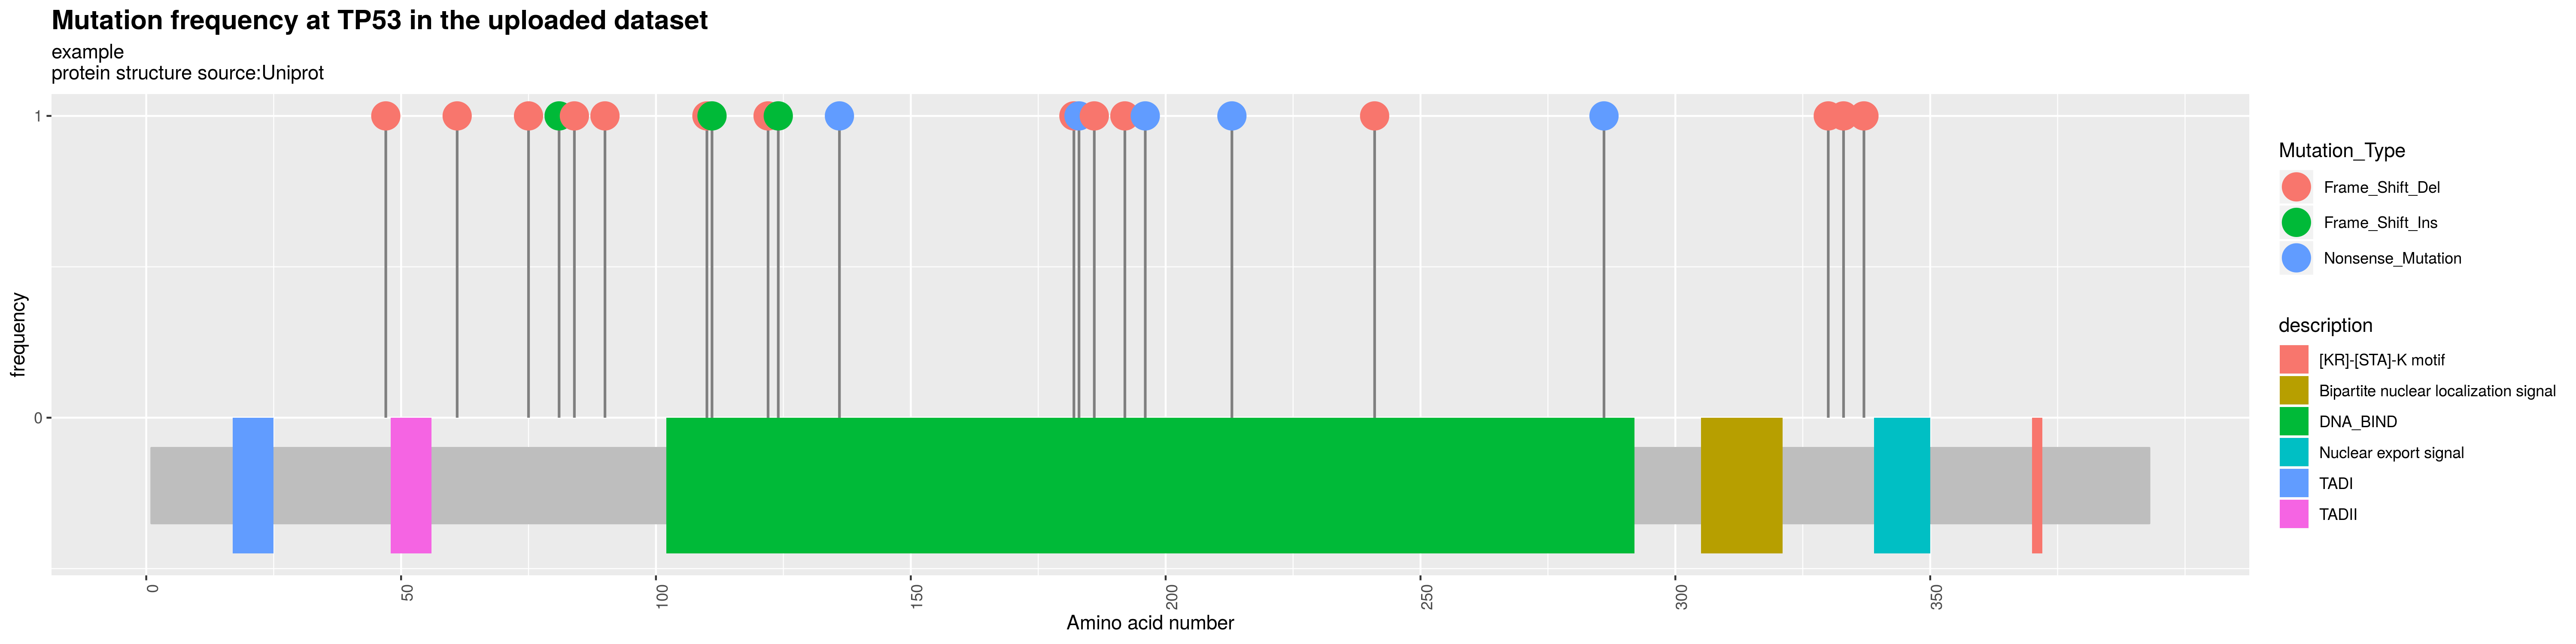

Now, you try a gene. Use the **endometrial** data set and make a lollipop plot for truncations in the **PTEN** gene. Follow the same steps we used to make the plot for TP53 gene above to get the new plot.

In [ ]:
#Make PTEN plot.
###      Your code here      ###

cptac.download('endometrial')
en = cptac.Endometrial()

en_mutations = en.get_somatic_mutation()
en_mutations



Name,Gene,Mutation,Location
Patient_ID,,,
C3L-00006,AAK1,Missense_Mutation,p.A592V
C3L-00006,AANAT,Missense_Mutation,p.R176W
C3L-00006,ABCA12,Frame_Shift_Del,p.N1671Ifs*4
C3L-00006,ABCC4,Missense_Mutation,p.R691H
C3L-00006,ABL1,Missense_Mutation,p.G273R
...,...,...,...
C3N-01825,TGFB3,Missense_Mutation,p.E240K
C3N-01825,TP53,Missense_Mutation,p.R175H
C3N-01825,WDFY4,Missense_Mutation,p.R1233L


In [ ]:
en_pten = en_mutations.loc[(en_mutations['Gene'] == 'PTEN') & ((en_mutations['Mutation'] == 'Frame_Shift_Del') | (en_mutations['Mutation'] == 'Frame_Shift_Ins') |
                                                     (en_mutations['Mutation'] == 'Nonsense_Mutation'))]
en_pten

Name,Gene,Mutation,Location
Patient_ID,,,
C3L-00006,PTEN,Nonsense_Mutation,p.R233*
C3L-00032,PTEN,Nonsense_Mutation,p.W111*
C3L-00137,PTEN,Frame_Shift_Ins,p.H118Qfs*8
C3L-00137,PTEN,Nonsense_Mutation,p.Y180*
C3L-00145,PTEN,Frame_Shift_Ins,p.E242*
...,...,...,...
C3N-01349,PTEN,Nonsense_Mutation,p.R130*
C3N-01510,PTEN,Nonsense_Mutation,p.R130*
C3N-01510,PTEN,Nonsense_Mutation,p.R233*


In [ ]:
en_mutplot_df = en_pten.reset_index()
en_mutplot = en_mutplot_df.rename(columns = {'Patient_ID':'Sample_ID', 'Gene':'Hugo_Symbol','Mutation':'Mutation_Type','Location':'Protein_Change'})
en_mutplot

en_mutplot.to_csv('en_pten.csv', '\t')
files.download('en_pten.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##PRACTICE PROBLEMS
These questions relate to the PTEN lollipop plot you have just created.

Since these questions are based on looking at a graph, no coding is necessary. Simply set each answer variable equal to a string consisting of your answer based on the lollipop plot you made.

6. Which nonsense mutation location has the highest frequency of occurences?

In [ ]:
###       Question 6         ###
#  Which nonsense mutation location has the highest frequency of occurences?
#  Your answer should be the complete mutation nomenclature. e.g. p.F276*

answer_6 = 'p.R233*'


In [ ]:
###  Question 6: Submitting the answer   ###
# To submit, create a variable above named 'answer_6' set equal to your answer based on the lollipop plot you made.
result = hw.submit(question = 6, answer = answer_6)
print(result)

True


In [ ]:
### Question 6: Getting help ###
hints = hw.getHint(question=6)
print(hints)

7. What is the location of the earliest frameshift deletion?

In [ ]:
###       Question 7         ###
#  What is the location of the earliest frameshift deletion?
#  Your answer should be the complete mutation nomenclature. e.g. p.L342Wfs*22

answer_7 = 'p.N12Tfs*12'


In [ ]:
###  Question 7: Submitting the answer   ###
# To submit, create a variable above named 'answer_7' set equal to your answer based on the lollipop plot you made.
result = hw.submit(question = 7, answer = answer_7)
print(result)

True


In [ ]:
### Question 7: Getting help ###
hints = hw.getHint(question=7)
print(hints)

# Part 5. Turn it in
**Congrats!**

Now that you have finished the assignment, use the endSession command to report your score. Once you have completed the notebook, please share it with your instructor.

In [ ]:
hw.endSession()


                      SESSION SUMMARY                       
------------------------------------------------------------
Student ID:                                           s15211
Homework:                                         bio462_hw3
------------------------------------------------------------
  Question  |  Correct  |  Attempts  |        Answer        
     1      |    Yes    |     1      |   22
     2      |    Yes    |     1      |   04OV031, 17OV036, 26OV008
     3      |    No     |     1      |   01OV007, 01OV017, 01OV018, 01OV026, 01OV039, 01OV047, 02OV005, 02OV006, 02OV029, 02OV036, 02OV041, 02OV044, 02OV046, 04OV001, 04OV004, 04OV005, 04OV008, 04OV011, 04OV013, 04OV017, 04OV018, 04OV021, 04OV036, 04OV039, 04OV044, 04OV048, 04OV049, 04OV053, 04OV055, 04OV057, 04OV063, 11OV002, 14OV011, 15OV001, 17OV001, 17OV002, 17OV010, 17OV015, 17OV025, 17OV028, 17OV029, 17OV030, 17OV033, 17OV039, 26OV002, 26OV008
     4      |    Yes    |     1      |   22
     5      |    Yes    